# Inspect the parameters from fitting to the PK2015 idealised runs

Plot:
 - model overview (EKE, coherent ITs)
 - incoherent IT parameters (spatial)
 - example spectra (Lorentzian vs full model)

scatter:

  - eta_m vs tau_D2
  - eta_m vs gamma_D2

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from cmocean import cm
import seaborn as sns

import pk2015_utils as utils

import speccy
import nonstat_itides_jax as nsjax
import nonstat_itides as nsit

In [5]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='medium'
plt.rcParams['pcolor.shading']='auto'

In [6]:
limits = {
    'η_m':[0., 0.6],
    'τ_m':[0,20],
    'γ_m':[1,2.],
    'η_D2':[0, 0.2],
    'τ_D2':[0,15],
    'γ_D2':[1,2.],
}
scenarios = ['wp5','wp6','wp75','wp8','wp9']
scenario_names = ['KE1','KE2','KE2.5','KE3','KE4']

In [7]:
ds['data'].attrs['parameter names']
acf = nsjax.gamma_exp_1d

def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)

def calc_integral_scale(ds, idxm=[0,1,2], idxt=[3,4,5]  ): 
    data=ds['data'].values
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T = np.zeros((n,2))

    for ii in range(n):
        T[ii,0] = integral_timescale(acf, data[ii,idxm])
        T[ii,1] = integral_timescale(acf, data[ii,idxt])

    return xr.DataArray(T, dims=('y_vy','Tparams'))        


NameError: name 'ds' is not defined

In [8]:
paramnames[3].replace('D2','{D2}')

NameError: name 'paramnames' is not defined

In [9]:
labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)']

def plot_spatial(ds):
    ny, nparams = ds['data'].shape
    paramnames = ds['data'].attrs['parameter names']
    y = ds['nav_lat_vy']/1e3
    
    plt.figure(figsize=(6,nparams*1.2))
    axs=[]
    for ii in range(nparams):
        axs.append(plt.subplot(nparams,1,ii+1))
        axs[ii].plot(y, ds['data'][:,ii],'.')
        axs[ii].set_ylabel(f"${paramnames[ii].replace('D2','{D2}')}$")
        axs[ii].set_ylim(limits[paramnames[ii]])
        axs[ii].set_xlim(1000,2000)
        axs[ii].grid(True, ls=':')
        axs[ii].text(0.02, 0.8, labels[ii], transform=axs[ii].transAxes)
        if ii < nparams-1:
            axs[ii].set_xticklabels([])

    
    axs[0].annotate('', xy=(1500+50, 0.25), xytext=(1500+50, 0.05),
            arrowprops=dict(facecolor='0.5', shrink=0.02),
            )
    axs[0].annotate('', xy=(1500+100, 0.25), xytext=(1500+100, 0.05),
            arrowprops=dict(facecolor='0.5', shrink=0.02),
            )
    axs[0].annotate('', xy=(1500, 0.25), xytext=(1500, 0.05),
            arrowprops=dict(facecolor='0.5', shrink=0.02),
            )
    return axs

def append_time_plot(ds, axs):
    y = ds['nav_lat_vy']/1e3
    T = calc_integral_scale(ds).values
    axs[1].plot(y, T[:,0],'r.', ms=1)
    axs[4].plot(y, T[:,1],'r.', ms=1)
    axs[4].legend(('τ','T'), loc=(0.8,0.6))

NameError: name 'calc_integral_scale' is not defined

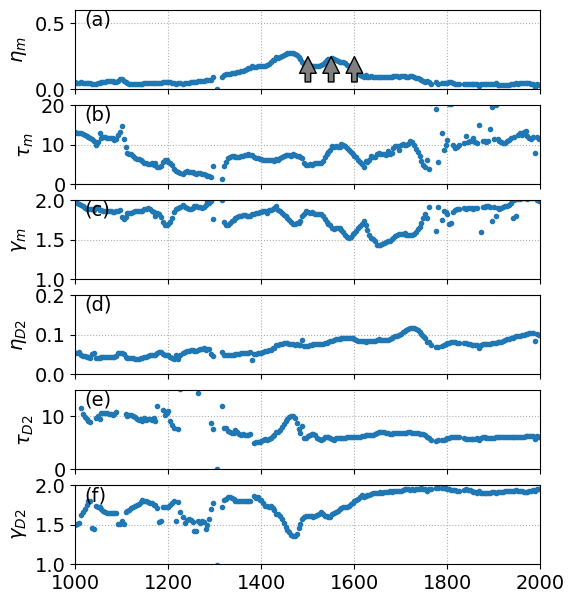

In [10]:
covfunc = nsjax.itide_D2_meso_gammaexp
# covfunc = nsjax.itide_D2_meso_gammaexp_fixed
# varname = 'u_y'
varname = 'v_y'


for scenario, name in zip(scenarios, scenario_names):
    output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
    ds = xr.open_dataset(output_nc)
    axs=plot_spatial(ds)
    append_time_plot(ds, axs)
    axs[0].set_title(name)
    axs[-1].set_xlabel('y [km]')    
    plt.savefig('../FIGURES/PK2015_spatialparams_GammaExp_{}_{}_v2.png'.format(scenario, varname), dpi=150)

In [13]:
def scatter(ax, xidx, yidx, covfunc, cmap='Dark2', 
            legend=False, xticks=False, yticks=False):
    cmap = plt.colormaps.get_cmap(cmap)
    colors = [cmap(ii) for ii in np.linspace(0,1,5)]
    # Add the mean value
    for cc, scenario in zip(colors, scenarios):
        output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
        ds = xr.open_dataset(output_nc)
    
        ax.plot(ds['data'][:,xidx].mean(), ds['data'][:,yidx].mean(),'^',
                c=cc, ms=10, zorder=1e6, markeredgecolor='k'  )
    if legend:
        ax.legend(scenario_names)
    
    for cc, scenario in zip(colors, scenarios):
        output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
        ds = xr.open_dataset(output_nc)
    
        ax.plot(ds['data'][:,xidx], ds['data'][:,yidx],'.',c=cc, alpha=0.2)
    
    paramnames = ds['data'].attrs['parameter names']
    ax.set_ylim(limits[paramnames[yidx]])
    ax.set_xlim(limits[paramnames[xidx]])

    plt.grid(True, ls=':')

    if xticks:
        #ax.set_xlabel(paramnames[xidx])
        ax.set_xlabel(f"${paramnames[xidx].replace('D2','{D2}')}$")
    else:
        ax.set_xticklabels([])

    if yticks:
        #ax.set_ylabel(paramnames[yidx])
        ax.set_ylabel(f"${paramnames[yidx].replace('D2','{D2}')}$")
    else:
        ax.set_yticklabels([])
   
def scatter_length(ax, yidx, covfunc, cmap='Dark2', 
            legend=False, xticks=False, yticks=False):
    cmap = plt.colormaps.get_cmap(cmap)
    colors = [cmap(ii) for ii in np.linspace(0,1,5)]
    # Add the mean value
    for cc, scenario in zip(colors, scenarios):
        output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
        ds = xr.open_dataset(output_nc)

        xdata = ds['data'][:,0] * ds['data'][:,1]*86400 / 1000 # km
    
        ax.plot(xdata.mean(), ds['data'][:,yidx].mean(),'^',\
                c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    if legend:
        ax.legend(scenario_names)
    
    for cc, scenario in zip(colors, scenarios):
        output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
        ds = xr.open_dataset(output_nc)

        xdata = ds['data'][:,0] * ds['data'][:,1]*86400 / 1000 # km
        ax.plot(xdata, ds['data'][:,yidx],'.',c=cc, alpha=0.2)
    
    paramnames = ds['data'].attrs['parameter names']
    ax.set_ylim(limits[paramnames[yidx]])
    #ax.set_xlim(limits[paramnames[xidx]])

    plt.grid(True, ls=':')

    if xticks:
        ax.set_xlabel('ℓ_m')
    else:
        ax.set_xticklabels([])

    if yticks:
        #ax.set_ylabel(paramnames[yidx])
        ax.set_ylabel(f"${paramnames[yidx].replace('D2','{D2}')}$")
    else:
        ax.set_yticklabels([])
   

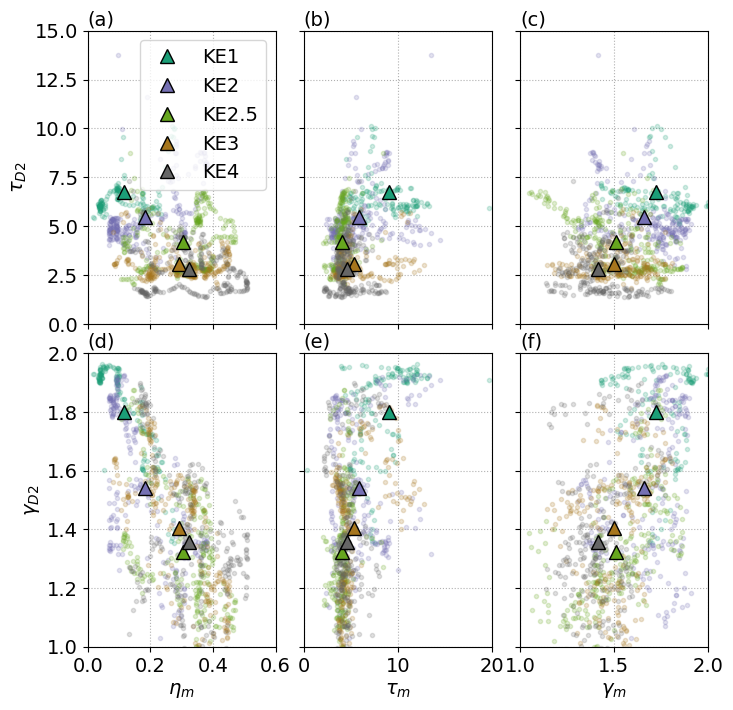

In [14]:
# Scatter plot of various parameters

covfunc = nsjax.itide_D2_meso_gammaexp

plt.figure(figsize=(8,8))
ax1 = plt.subplot(231)
scatter(ax1, 0, 4, covfunc, yticks=True, legend=True)
ax1.text(0.0, 1.02, '(a)', transform=ax1.transAxes)

ax2 = plt.subplot(234)
scatter(ax2, 0, 5, covfunc, xticks=True, yticks=True)
ax2.text(0.0, 1.02, '(d)', transform=ax2.transAxes)

ax3 = plt.subplot(232)
scatter(ax3, 1, 4, covfunc)
ax3.text(0.0, 1.02, '(b)', transform=ax3.transAxes)

ax4 = plt.subplot(235)
scatter(ax4, 1, 5, covfunc, xticks=True)
ax4.text(0.0, 1.02, '(e)', transform=ax4.transAxes)

ax5 = plt.subplot(233)
scatter(ax5, 2, 4, covfunc)
ax5.text(0.0, 1.02, '(c)', transform=ax5.transAxes)

ax6 = plt.subplot(236)
scatter(ax6, 2, 5, covfunc, xticks=True)
ax6.text(0.0, 1.02, '(f)', transform=ax6.transAxes)

plt.subplots_adjust( wspace=0.15, hspace=0.1)
plt.savefig(f'../FIGURES/PK2015_mesoscale_vs_itide_params_{varname}_v2.png', dpi=150)

# Scatter plot of eta_m vs tau_D2

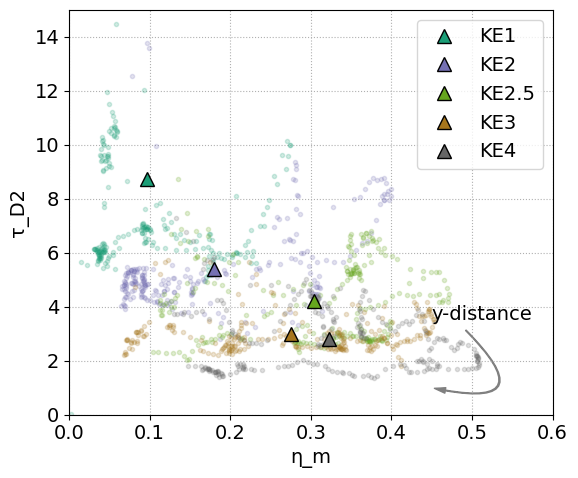

In [20]:
from matplotlib.patches import FancyArrowPatch

plt.figure(figsize=(6,5))
ax=plt.subplot(111)

covfunc = nsjax.itide_D2_meso_gammaexp

# Add the mean value
for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0].mean(), ds['data'][:,4].mean(),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
plt.legend(scenario_names)

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,4],'.',c=cc, alpha=0.2)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[0])
# ax.set_ylim(limits['τ_D2'])
ax.set_xlim(limits['η_m'])
ax.set_ylim(0, 15)

plt.grid(True, ls=':')

# ax.annotate('distance', xy=(0.53, 1.8), xytext=(0.39, 4),
#             arrowprops=dict(facecolor='0.5', shrink=0.05),
#             )
# ax.annotate('', xy=(0.45, 1), xytext=(0.53, 1.8),
#             arrowprops=dict(facecolor='0.5', shrink=0.05),
#             )

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="0.5")
a3 = FancyArrowPatch((0.49, 3.2), (0.45, 1),
                             connectionstyle="arc3,rad=-1.7", **kw )
plt.gca().add_patch(a3)
plt.text(0.45, 3.5, 'y-distance')
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_tauD2_vs_etam_v2.png', dpi=150)

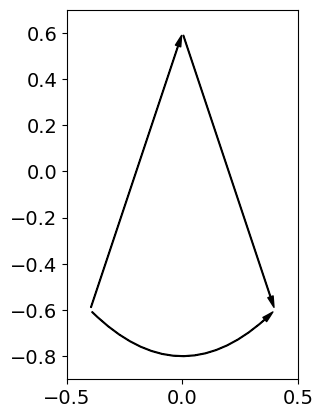

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
 
plt.figure()
plt.gca().set_xlim(-.5,0.5)
plt.gca().set_ylim(-0.9,0.7)
plt.gca().set_aspect(1)
 
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
 
a1 = patches.FancyArrowPatch((-0.4, -0.6), (0, 0.6), **kw)
a2 = patches.FancyArrowPatch((0, 0.6), (0.4, -0.6), **kw)
a3 = patches.FancyArrowPatch((-0.4, -0.6), (0.4, -0.6),
                             connectionstyle="arc3,rad=.5", **kw)
 
for a in [a1, a2, a3]:
    plt.gca().add_patch(a)
plt.show()
 
 
 
 

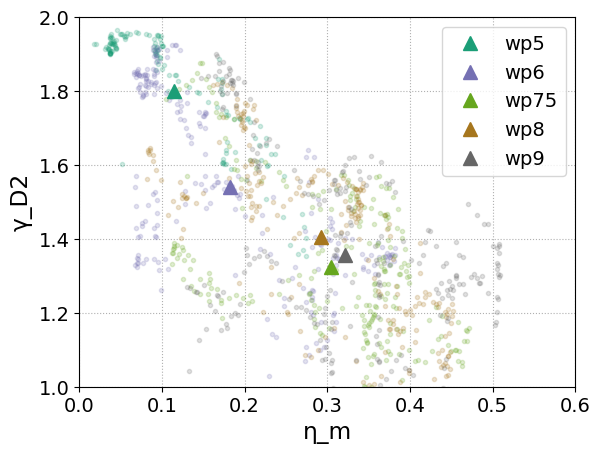

In [15]:
plt.figure()
ax=plt.subplot(111)
covfunc = nsjax.itide_D2_meso_gammaexp
for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0].mean(), ds['data'][:,5].mean(),'^',c=cc, ms=10, zorder=1e6 )
plt.legend(scenarios)

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,5],'.',c=cc, alpha=0.2)




paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[5])
ax.set_xlabel(paramnames[0])
ax.set_ylim(limits['γ_D2'])
ax.set_xlim(limits['η_m'])

plt.legend(scenarios)
plt.grid(True, ls=':')
plt.savefig('../FIGURES/PK2015_gammaD2_vs_etam.png', dpi=150)

# eta_D2 vs eta_m

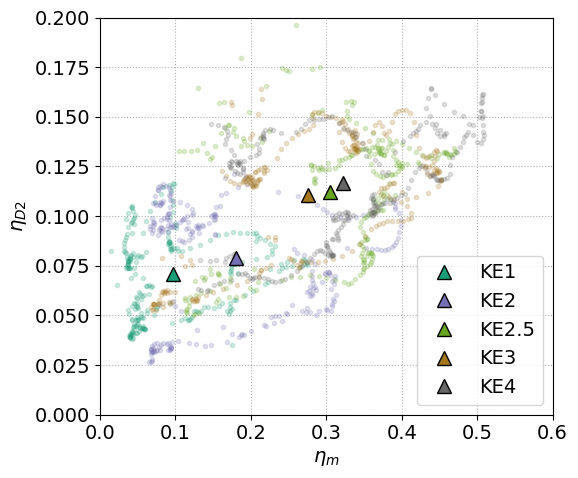

In [16]:
cmap = plt.colormaps.get_cmap('Dark2')
colors = [cmap(ii) for ii in np.linspace(0,1,5)]

plt.figure(figsize=(6,5))
ax=plt.subplot(111)

covfunc = nsjax.itide_D2_meso_gammaexp

# Add the mean value

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
    ds = xr.open_dataset(output_nc)

    #plt.plot(ds['data'][-100:,0].mean(), ds['data'][-100:,3].mean(),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    plt.plot(ds['data'][:,0].mean(), ds['data'][:,3].mean(),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
plt.legend(scenario_names)

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_{}_v2.nc'.format(scenario,covfunc.__name__, varname)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,0], ds['data'][:,3],'.',c=cc, alpha=0.2)
    #plt.plot(ds['data'][-100:,0], ds['data'][-100:,3],'.',c=cc, alpha=0.2)



paramnames = ds['data'].attrs['parameter names']
# ax.set_ylabel(paramnames[3])
# ax.set_xlabel(paramnames[0])
ax.set_ylabel(f"${paramnames[3].replace('D2','{D2}')}$")
ax.set_xlabel(f"${paramnames[0].replace('D2','{D2}')}$")
ax.set_ylim(limits['η_D2'])
ax.set_xlim(limits['η_m'])
# ax.set_ylim(0, 15)

plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig(f'../FIGURES/PK2015_etaD2_vs_etam_{varname}_v3.png', dpi=150)

# tau_D2 vs tau_m

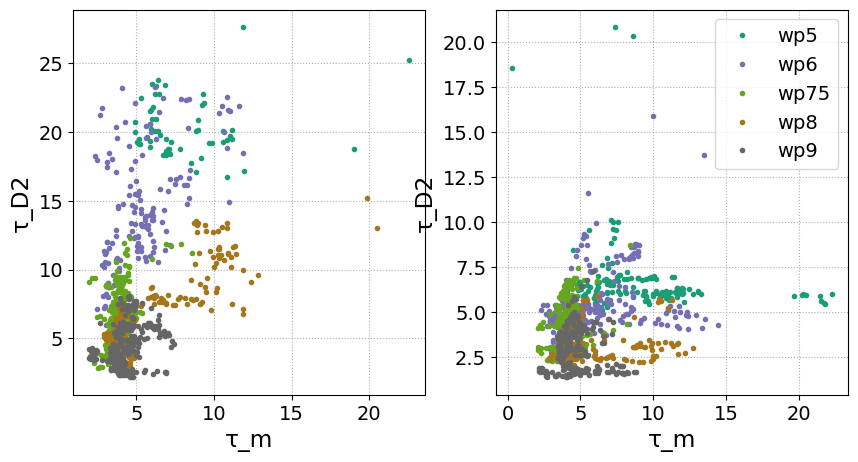

In [15]:
plt.figure(figsize=(10,5))
ax=plt.subplot(121)
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,1], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[1])
plt.grid(True, ls=':')

ax=plt.subplot(122)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,1], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[1])
plt.legend(scenarios)
plt.grid(True, ls=':')
# plt.savefig('../FIGURES/PK2015_taum_vs_tauD2.png', dpi=150)

# Integral time scales


9.229236167141835 5.474102731679928
4.229912914866922 4.319362223545922
3.8001230036427005 2.5706575156664186
3.7579499282560507 2.2809086141842956
4.27636225791563 1.536284574155222


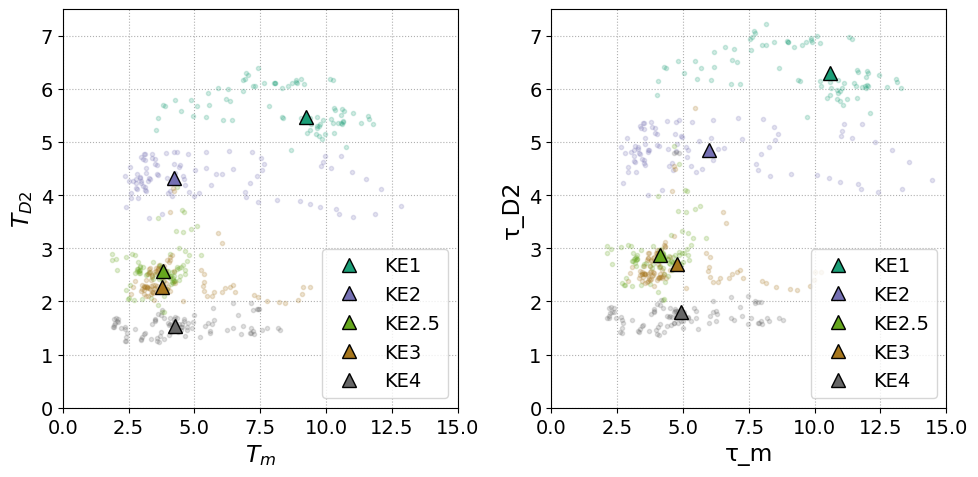

In [25]:
def integral_timescale(covfunc, covparams, tmax=500, N=1000):
    t = np.linspace(0, tmax, N) # days

    acf = covfunc(t, t[0], covparams)
    
    return 1./covparams[0]**2 * np.trapz(acf, t)

plt.figure(figsize=(10,5))
ax=plt.subplot(121)

acf = nsjax.gamma_exp_1d

covfunc = nsjax.itide_D2_meso_gammaexp
p=[]
for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)
    data=ds['data'].values[-100:,:]
    #data[:,0] = 1.
    #data[:,3] = 1.
    n = data.shape[0]
    T_meso = np.zeros((n,))
    T_it = np.zeros((n,))
    for ii in range(n):
        T_meso[ii] = integral_timescale(acf, data[ii,0:3])
        T_it[ii] = integral_timescale(acf, data[ii,3::])

    idx = ~np.isnan(T_meso)
    p1, = plt.plot(np.median(T_meso[idx]), np.median(T_it[idx]),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
    #plt.plot(T_meso*data[:,0]*86400/1000, T_it,'.',c=cc, alpha=0.2)
    plt.plot(T_meso, T_it,'.',c=cc, alpha=0.2)
    p.append(p1)

    print(np.median(T_meso[idx]), np.median(T_it[idx]))
#     #
plt.legend(p, scenario_names)

# paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel('$T_{D2}$')
ax.set_xlabel('$T_m$')
ax.set_ylim(0,7.5)
#ax.set_xlim(0,250)
ax.set_xlim(0, 15)

plt.grid(True, ls=':')
# plt.tight_layout()

ax=plt.subplot(122)

covfunc = nsjax.itide_D2_meso_gammaexp

# Add the mean value

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][-100:,1].mean(), ds['data'][-100:,4].mean(),'^',c=cc, ms=10, zorder=1e6, markeredgecolor='k' )
plt.legend(scenario_names)

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][-100:,1], ds['data'][-100:,4],'.',c=cc, alpha=0.2)



paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[1])
ax.set_ylim(0,7.5)
ax.set_xlim(0, 15)
# ax.set_ylim(0, 15)

plt.grid(True, ls=':')
plt.tight_layout()


In [53]:
ds['data'].shape

(250, 6)

# tau_D2 vs gamma_m 

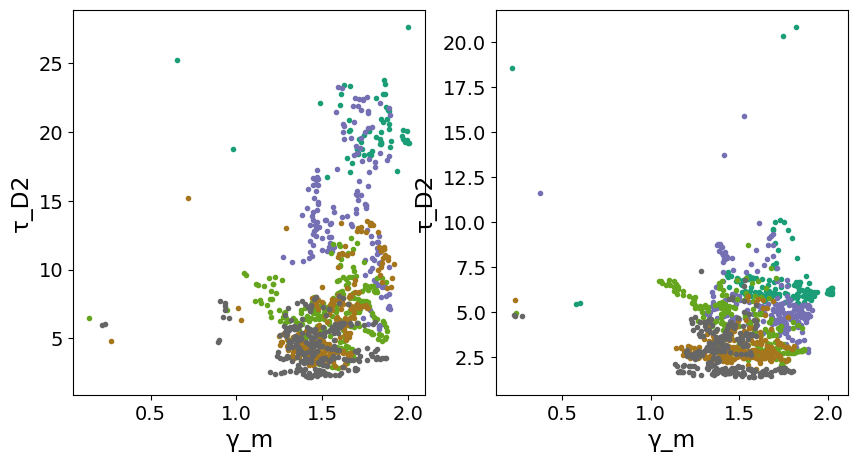

In [18]:
plt.figure(figsize=(10,5))
ax=plt.subplot(121)
covfunc = nsjax.itide_D2_meso_gammaexp_fixed

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[2])

ax=plt.subplot(122)
covfunc = nsjax.itide_D2_meso_gammaexp

for cc, scenario in zip(colors, ['wp5','wp6','wp75','wp8','wp9']):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2], ds['data'][:,4],'.',c=cc)

paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[2])
plt.savefig('../FIGURES/PK2015_gammam_vs_tauD2.png', dpi=150)

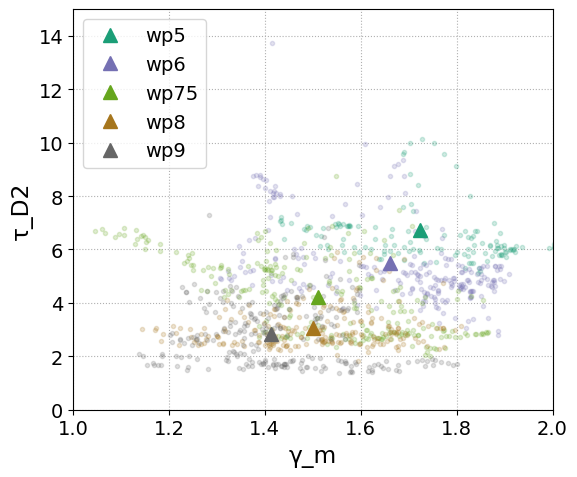

In [19]:
plt.figure(figsize=(6,5))
ax=plt.subplot(111)

covfunc = nsjax.itide_D2_meso_gammaexp

# Add the mean value

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2].mean(), ds['data'][:,4].mean(),'^',c=cc, ms=10, zorder=1e6 )
plt.legend(scenarios)

for cc, scenario in zip(colors, scenarios):
    output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
    ds = xr.open_dataset(output_nc)

    plt.plot(ds['data'][:,2], ds['data'][:,4],'.',c=cc, alpha=0.2)



paramnames = ds['data'].attrs['parameter names']
ax.set_ylabel(paramnames[4])
ax.set_xlabel(paramnames[2])
# ax.set_ylim(limits['τ_D2'])
# ax.set_xlim(limits['γ_m'])

ax.set_xlim(1,2)
ax.set_ylim(0, 15)

plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_tauD2_vs_gammam.png', dpi=150)

In [10]:
def load_scenario(scenario):
    ncfiles = {'wp5':
             [
             '../DATA/ROMS/wp5/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp5/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp5/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp5/t3/file_inst_00010220-00010410.nc'
             ],
               'wp6':
             [
             '../DATA/ROMS/wp6/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp6/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp6/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp6/t2/inst_00010220-00010410.nc',
             ],
               'wp75':
             [
             '../DATA/ROMS/wp75/t1/inst_00010101-00010219.nc',
             '../DATA/ROMS/wp75/t1/inst_00010220-00010410.nc',
            '../DATA/ROMS/wp75/t2/inst_00010101-00010219.nc',
            '../DATA/ROMS/wp75/t2/inst_00010220-00010410.nc',
             ],
                'wp8':
             [
             '../DATA/ROMS/wp8/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp8/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp8/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp8/t3/file_inst_00010220-00010410.nc'
             ],
               'wp9':
             [
             '../DATA/ROMS/wp9/t1/file_inst_00010101-00010219.nc',
             '../DATA/ROMS/wp9/t1/file_inst_00010220-00010410.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010101-00010219.nc',
            '../DATA/ROMS/wp9/t2/file_inst_00010220-00010410.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010101-00010219.nc',
              #'../DATA/ROMS/wp9/t3/file_inst_00010220-00010410.nc'
             ],
              }
    
    ds0 = xr.open_mfdataset(ncfiles[scenario][0:2])
    ds1 = xr.open_mfdataset(ncfiles[scenario][2:4])
    
    dt1 = ds0['time_instant'][-1]-ds0['time_instant'][0]
    ds1['time_instant'] = ds1['time_instant']+dt1
    ds1['time_counter'] = ds1['time_counter']+dt1

    if len(ncfiles[scenario])>4:
        ds2 = xr.open_mfdataset(ncfiles[scenario][4:6])
        dt2 = ds1['time_instant'][-1]-ds1['time_instant'][0]
        
        ds2['time_instant'] = ds2['time_instant']+dt1+dt2
        ds2['time_counter'] = ds2['time_counter']+dt1+dt2

        return xr.concat([ds0, ds1, ds2], dim='time_counter')

    else:
        return xr.concat([ds0, ds1], dim='time_counter')
        

In [11]:
def plot_site(ds, dsfull, ypt, c, covfunc, dt, nparams=2):
    dist = np.abs(ds['nav_lat_vy']-ypt).values
    ii = np.argwhere(dist==np.min(dist))[0][0]
    params_pt = ds['data'].isel(y_vy=ii)
    t_ = ds['time_instant'] - ds['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    print(params_pt.values)
    acf = covfunc(t, t[0], params_pt.values)

    dist = np.abs(dsfull['nav_lat_vy']-ypt).values
    ii = np.argwhere(dist==np.min(dist))[0][0]
    y = dsfull['v_y'].isel(y_vy=ii).values.squeeze()
    print(y.shape)
    f, I =  nsjax.periodogram(y.squeeze(), delta=dt)
    f_S, S = nsjax.bochner(acf, delta=dt)
    p1, = plt.loglog(f, 2*I, 'navy',  lw=0.3)
    p2, = plt.loglog(f_S,S,c, ls='--', lw=2)
    ax.set_ylim(1e-7, 10)
    plt.xlim(5e-3, 3)
    plt.xlabel('f [cpd]')
    #plt.plot(t, y[:,0,0])
    return p1, p2

[ 0.14136806  6.84661     1.627725    0.07786797 23.466465  ]
(9600,)
[0.14531657 7.1749706  1.5862614  0.0881786  6.0941086  1.7953527 ]
(9600,)
[ 0.14136806  6.84661     1.627725    0.07786797 23.466465  ]
(9600,)
[0.14531657 7.1749706  1.5862614  0.0881786  6.0941086  1.7953527 ]
(9600,)


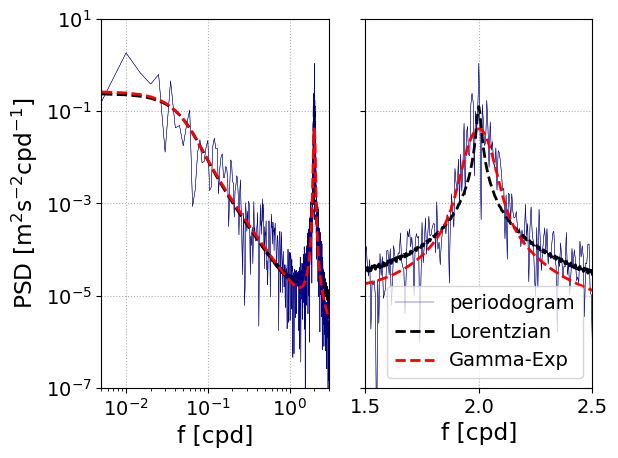

In [12]:
# Highlight the difference between Lorentzian and GammaExp
scenario = 'wp5'
ypt = 1600000.

# scenario = 'wp9'
# ypt = 1600000.

dt = 0.5/24

covfunc = nsjax.itide_D2_meso_gammaexp_fixed
output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
ds = xr.open_dataset(output_nc)

covfunc2 = nsjax.itide_D2_meso_gammaexp
output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc2.__name__)
ds2 = xr.open_dataset(output_nc)

dsfull = load_scenario(scenario)


plt.figure()
ax=plt.subplot(121)
plot_site(ds, dsfull, ypt, 'k', covfunc, dt)
plot_site(ds2, dsfull, ypt, 'r', covfunc2, dt)
plt.grid(True, ls=':')
plt.ylabel('PSD [m$^2$s$^{-2}$cpd$^{-1}$]')
ax=plt.subplot(122)
p1,p2 = plot_site(ds, dsfull, ypt, 'k', covfunc, dt)
_, p3 = plot_site(ds2, dsfull, ypt, 'r', covfunc2, dt)
ax.set_yticklabels([])
ax.set_xlim(1.5,2.5)
ax.set_xscale('linear')
plt.legend((p1, p2, p3), ('periodogram','Lorentzian','Gamma-Exp'))
plt.grid(True, ls=':')
plt.tight_layout()
plt.savefig('../FIGURES/PK2015_gammaexp_vs_Lorentzian.png', dpi=150)

In [13]:
from tqdm import tqdm
# Spectrogram (y-omega)
scenario = 'wp9'
dt = 0.5/24

dsfull = load_scenario(scenario)
v = dsfull['v_y'].values.squeeze()


covfunc = nsjax.itide_D2_meso_gammaexp
output_nc = '../DATA/ROMS/{}_params_{}_v2.nc'.format(scenario,covfunc.__name__)
ds = xr.open_dataset(output_nc)
ny = ds.dims['y_vy']
t_ = ds['time_instant'] - ds['time_instant'][0]
t = t_.values.astype(float)/1e9/86400

S_omegay = np.zeros((t.shape[0], ny))
I_omegay = np.zeros((t.shape[0], ny))

for ii in tqdm(range(ny)):
    t_ = ds['time_instant'] - ds['time_instant'][0]
    t = t_.values.astype(float)/1e9/86400
    params_pt = ds['data'].isel(y_vy=ii)
    acf = covfunc(t, t[0], params_pt.values)
    f_S, S = nsjax.bochner(acf, delta=dt)
    S_omegay[:,ii] = S

    #y = dsfull['v_y'].isel(y_vy=ii).values.squeeze()
    f, I =  nsjax.periodogram(v[:,ii], delta=dt)
    I_omegay[:,ii] = I

100%|██████████| 250/250 [00:03<00:00, 82.56it/s]


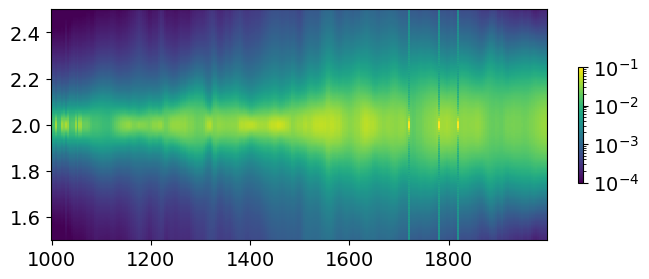

In [14]:
from matplotlib import colors
y = ds['nav_lat_vy'].values[:,0]/1e3

plt.figure(figsize=(8,3))
ax=plt.gca()
plt.pcolormesh( y, f_S,  S_omegay, norm=colors.LogNorm(vmin=1e-4, vmax=0.1), )
# plt.pcolormesh( y, f_S,  I_omegay, norm=colors.LogNorm(vmin=1e-6, vmax=1), )

# ax.set_yscale('log')
# ax.set_ylim(5e-2, 2.5)
ax.set_ylim(1.5, 2.5)
plt.colorbar(shrink=0.5)


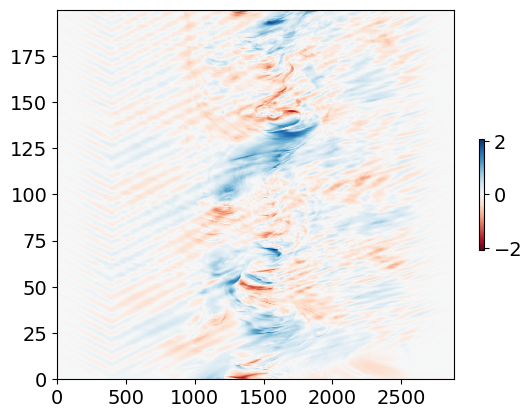

In [15]:
# Filter and plot the velocity
plt.figure()

v = dsfull['v_y'].values.squeeze()
y = dsfull['nav_lat_vy'].values[:,0]/1e3
t_ = ds['time_instant'] - ds['time_instant'][0]
tdays = t_.values.astype(float)/1e9/86400
tdays

plt.pcolormesh(y, t, v, cmap='RdBu')
plt.colorbar(shrink=0.3)


In [ ]:
vlow = utils.filt(v, 12*3600, dt*3600, btype='low', axis=0)

(500.0, 2500.0)

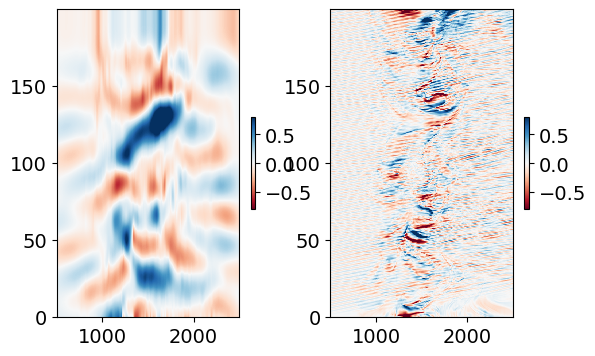

In [20]:
plt.figure(figsize=(10,4))
ax=plt.subplot(131)
plt.pcolormesh(y, t, vlow, cmap='RdBu', vmin=-0.8, vmax=0.8)
plt.colorbar(shrink=0.3)
ax.set_xlim(500,2500)
ax=plt.subplot(132)
plt.pcolormesh(y, t, v-vlow, cmap='RdBu', vmin=-0.8, vmax=0.8)
plt.colorbar(shrink=0.3)
ax.set_xlim(500,2500)

In [43]:
vlow.shape, v.shape

((9600, 721), (9600, 721))

In [46]:
dt

0.020833333333333332